<a href="https://colab.research.google.com/github/yasukenn/Atcoder_ABC/blob/main/%5Bminpaku%5D2_2_2_model2(lightgbm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0：ドライブマウント**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1-1:インストールゾーン**

In [2]:
! pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 14.8 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=c3827cd9abb526b5313c1f5bbfe643053c1b16fef9a4882e7c956299b72abd55
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [3]:
! pip install optuna

     |████████████████████████████████| 308 kB 13.2 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 210 kB 58.2 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 113 kB 49.0 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 150 kB 49.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=81c620a8489a295acd1167978eb178ab909986cdd0d14448577a08efa788a878
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# **1-2：インポートゾーン**

In [4]:
# ライブラリのインポート
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import gc

# LightGBMのインポート
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb

# scikitlearnから前処理用のライブラリのインポート
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# scikitlearnから評価用のライブラリをインポート
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 初期設定
sns.set_style('whitegrid',{'linestyle.grid':'--'})
%matplotlib inline

# **2-1:データセット読み込み**

In [82]:
train_df = pd.read_csv("/content/drive/MyDrive/PROBSPACE/minpaku/data/train_data.csv", index_col='id')
test_df = pd.read_csv("/content/drive/MyDrive/PROBSPACE/minpaku/data/test_data.csv")

train_df.shape, test_df.shape

((9990, 12), (4996, 12))

# **2-2:データの加工**

In [83]:
#目的変数の定義
target = train_df['y']

In [84]:
#トレーニングデータとテストデータ合体
'''
トレーニングデータとテストデータを繋げることで
前処理動作が簡単になる。
'''
data_df = pd.concat([train_df, test_df])
data_df.drop("id", axis=1,inplace=True)
print(data_df.shape)
data_df.head()

(14986, 12)


,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y
1,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,242899459,Koto Ku,35.68185,139.80310,Entire home/apt,1,55,2020-04-25,2.21,173,12008.0
2,Downtown Tokyo Iriya next to Ueno,308879948,Taito Ku,35.72063,139.78536,Entire home/apt,6,72,2020-03-25,2.11,9,6667.0
3,"Japan Style,Private,Affordable,4min to Sta.",300877823,Katsushika Ku,35.74723,139.82349,Entire home/apt,1,18,2020-03-23,3.46,288,9923.0
4,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,236935461,Shibuya Ku,35.68456,139.68077,Entire home/apt,1,2,2020-04-02,1.76,87,8109.0
5,LICENSED SHINJUKU HOUSE: Heart of the action!,243408889,Shinjuku Ku,35.69840,139.70467,Entire home/apt,1,86,2020-01-30,2.00,156,100390.0


In [85]:
# 今回使用する特徴量
#columns = ['neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews']

In [86]:
#変更１区ごとにグルーピング
data_df['group1'] = 0

data_df.loc[(data_df['neighbourhood'] == 'Chuo Ku') | 
            (data_df['neighbourhood'] == 'Chiyoda Ku') |
            (data_df['neighbourhood'] == 'Minato Ku') |
            (data_df['neighbourhood'] == 'Shibuya Ku') |
            (data_df['neighbourhood'] == 'Shinjyuku Ku'),
            'group1'] = 1

In [87]:
#変更１区ごとにグルーピング
data_df['group2'] = 0

data_df.loc[(data_df['neighbourhood'] == 'Toshima Ku') | 
            (data_df['neighbourhood'] == 'Taito Ku') |
            (data_df['neighbourhood'] == 'Bunkyo Ku') |
            (data_df['neighbourhood'] == 'Meguro Ku') |
            (data_df['neighbourhood'] == 'Shinagawa Ku'),
            'group2'] = 1

In [88]:
#変更１区ごとにグルーピング
data_df['group3'] = 0

data_df.loc[(data_df['neighbourhood'] == 'Nakano Ku') | 
            (data_df['neighbourhood'] == 'Setagaya Ku') |
            (data_df['neighbourhood'] == 'Suginami Ku') |
            (data_df['neighbourhood'] == 'Kita Ku') |
            (data_df['neighbourhood'] == 'Arakawa Ku'),
            'group3'] = 1

In [89]:
#変更１区ごとにグルーピング
data_df['group4'] = 0

data_df.loc[(data_df['neighbourhood'] == 'Koto Ku') | 
            (data_df['neighbourhood'] == 'Sumida Ku') |
            (data_df['neighbourhood'] == 'Ota Ku') |
            (data_df['neighbourhood'] == 'Itabashi Ku'),
            'group4'] = 1

In [90]:
#変更１区ごとにグルーピング
data_df['group5'] = 0

data_df.loc[(data_df['neighbourhood'] == 'Nerima Ku') | 
            (data_df['neighbourhood'] == 'Edogawa Ku') |
            (data_df['neighbourhood'] == 'Adachi Ku') |
            (data_df['neighbourhood'] == 'Itabashi Ku'),
            'group5'] = 1

In [91]:
# 今回使用する特徴量
columns = ['neighbourhood','room_type', 'minimum_nights', 'number_of_reviews','group1','group2','group3','group4','group5']

In [92]:
# 説明変数定義
data_df = pd.get_dummies(data_df[columns], drop_first=True)

In [93]:
data_df.head()

,minimum_nights,number_of_reviews,group1,group2,group3,group4,group5,neighbourhood_Arakawa Ku,neighbourhood_Bunkyo Ku,neighbourhood_Chiyoda Ku,...,neighbourhood_Shibuya Ku,neighbourhood_Shinagawa Ku,neighbourhood_Shinjuku Ku,neighbourhood_Suginami Ku,neighbourhood_Sumida Ku,neighbourhood_Taito Ku,neighbourhood_Toshima Ku,room_type_Hotel room,room_type_Private room,room_type_Shared room
1,1,55,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,72,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,1,86,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [94]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14986 entries, 1 to 4995
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   minimum_nights               14986 non-null  int64
 1   number_of_reviews            14986 non-null  int64
 2   group1                       14986 non-null  int64
 3   group2                       14986 non-null  int64
 4   group3                       14986 non-null  int64
 5   group4                       14986 non-null  int64
 6   group5                       14986 non-null  int64
 7   neighbourhood_Arakawa Ku     14986 non-null  uint8
 8   neighbourhood_Bunkyo Ku      14986 non-null  uint8
 9   neighbourhood_Chiyoda Ku     14986 non-null  uint8
 10  neighbourhood_Chuo Ku        14986 non-null  uint8
 11  neighbourhood_Edogawa Ku     14986 non-null  uint8
 12  neighbourhood_Itabashi Ku    14986 non-null  uint8
 13  neighbourhood_Katsushika Ku  14986 non-null  ui

# **2-3:データ再修正**

In [95]:
# 分割
train = data_df.iloc[:len(target), :]
test = data_df.iloc[len(target):, :]

#インデックス振り直し
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
target = target.reset_index(drop=True)
train.shape, test.shape

((9990, 32), (4996, 32))

# **3-1:モデルの構成**

In [96]:
# Kfold
cv = KFold(n_splits=5, shuffle=True, random_state=2020)
# RMSLE用
score = 0
# testデータの予測用
pred = np.zeros(test_df.shape[0])

In [97]:
target = np.log1p(target)

In [98]:
params = {
    'bagging_fraction': 0.9747075835171685,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'feature_fraction': 1.0,
 'feature_pre_filter': False,
 'lambda_l1': 0.00031164378112968774,
 'lambda_l2': 7.796109624576894e-07,
 'learning_rate': 0.01,
 'metric': 'rmse',
 'min_child_samples': 5,
 'n_jobs': -1,
 'num_leaves': 55,
 'objective': 'regression',
 'seed': 20,
 'verbose': -1
}

'bagging_fraction': 0.9747075835171685,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'feature_fraction': 1.0,
 'feature_pre_filter': False,
 'lambda_l1': 0.00031164378112968774,
 'lambda_l2': 7.796109624576894e-07,
 'learning_rate': 0.01,
 'metric': 'rmse',
 'min_child_samples': 5,
 'n_jobs': -1,
 'num_leaves': 55,
 'objective': 'regression',
 'seed': 20,
 'verbose': -1

# **3-2:モデルの学習**

In [99]:
for tr_idx, val_idx in cv.split(train):
    #trainとvalに分割
    x_train, x_val = train.iloc[tr_idx], train.iloc[val_idx]
    y_train, y_val = target[tr_idx], target[val_idx]
    
    # Datasetに入れて学習させる
    train_set = lgb.Dataset(x_train, y_train)
    val_set = lgb.Dataset(x_val, y_val, reference=train_set)
        
    # Training
    model = lgb.train(params, 
                      train_set, 
                      num_boost_round=8000, 
                      early_stopping_rounds=100,
                      valid_sets=[train_set, val_set], 
                      verbose_eval=500
                      )
    
    
    #テストデータを使った予測
    # 予測したらexpで元に戻す
    test_pred = np.expm1(model.predict(test))

    # 0より小さな値があるとエラーになるので補正
    test_pred = np.where(test_pred < 0, 0, test_pred)
    pred += test_pred / 5  #  5fold回すので

    #モデルの評価
    oof = np.expm1(model.predict(x_val))
    oof = np.where(oof < 0, 0, oof)

    #trainとvalのRSMLE評価
    rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), oof))
    print(f"RMSLE : {rmsle}")
    print()

    score += rmsle / 5 

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.732732	valid_1's rmse: 0.767733
Early stopping, best iteration is:
[440]	training's rmse: 0.737892	valid_1's rmse: 0.767077
RMSLE : 0.7670773558479789

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.730846	valid_1's rmse: 0.783091
Early stopping, best iteration is:
[549]	training's rmse: 0.727296	valid_1's rmse: 0.782616
RMSLE : 0.7826158502901513

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.73059	valid_1's rmse: 0.777016
Early stopping, best iteration is:
[425]	training's rmse: 0.736887	valid_1's rmse: 0.7769
RMSLE : 0.776899564825634

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.713694	valid_1's rmse: 0.837535
Early stopping, best iteration is:
[520]	training's rmse: 0.712111	valid_1's rmse: 0.837266
RMSLE : 0.8372655567574069

Training until validation scores don't impro

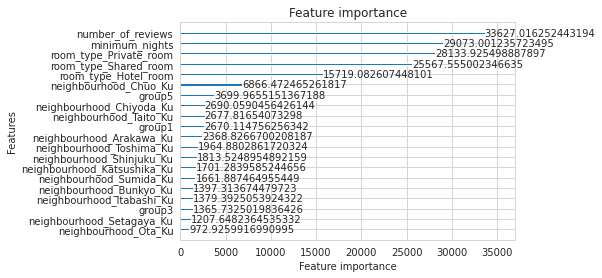

In [100]:
lgb.plot_importance(model, importance_type="gain", max_num_features=20)

In [101]:
print(f"Mean RMSLE SCORE :{score}")

Mean RMSLE SCORE :0.7872661194820976


In [102]:
score = 0

In [103]:
pred

array([15772.37463708, 14276.14822417, 12267.68231992, ...,
       14564.06439651,  3000.53224818,  8172.38918322])

# **4:結果提出**

In [104]:
submit_df = pd.DataFrame({"y": pred})
submit_df.index.name = "id"
submit_df.to_csv("/content/drive/MyDrive/PROBSPACE/minpaku/data/submission2-2-2.csv")